# I. US Living Kidney Donor Candidates

In [63]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import scipy as sp
from ipumspy import readers, ddi

## Candidate Pool
The [OPTN policies](<https://optn.transplant.hrsa.gov/media/eavh5bf3/optn_policies.pdf>) lists out the requirements for someone to be considered eligible to be a living kidney donor, the most significant of which are:
- Must be at least 18 years old.
- Cannot have HIV.
- Cannot have cancer.
- Cannot have uncontrollable hypertension.
- Cannot have diabetes.
- Must be of sound mind; cannot be suicidal.
Though the OPTN policies do allow for a small amount of flexibility with some of these requirements, we will treat them as strict for the purposes of our modelling.

We use data from the National Health Interview Survey (NHIS) to simulate the conditional distribution of the US living kidney donor candidate pool—that is, the pool of people meeting the above criteria.

In [122]:
nhis_data = readers.read_microdata(
    ddi=readers.read_ipums_ddi("C:/Users/brand/Desktop/STAR_Delimited/IPUMS Population Data/nhis_00001.dat/nhis_00001.xml"),
    filename="C:/Users/brand/Desktop/STAR_Delimited/IPUMS Population Data/nhis_00001.dat/nhis_00001.dat"
)
nhis_data.head()
nhis_data = nhis_data[nhis_data["YEAR"] == 2019]

C:\Users\brand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipumspy\readers.py:49: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.
  warnings.warn(


In [ ]:
nhis_data = nhis_data.replace({
    "HEIGHT" : {
        0 : np.nan,
        95 : np.nan,
        96 : np.nan,
        97 : np.nan,
        98 : np.nan,
        99 : np.nan,
    },
    "WEIGHT" : {
        0 : np.nan,
        996 : np.nan,
        997 : np.nan,
        998 : np.nan,
        999 : np.nan,
    },
    "AGE" : {
        997 : np.nan,
        998 : np.nan,
        999 : np.nan,
    },
    "DIABTYPE" : {
        7 : np.nan,
        8 : np.nan, 
        9 : np.nan,
    },
    "RACENEW" : {
        997 : np.nan,
        998 : np.nan, 
        999 : np.nan,
    },
})

In [123]:
nhis_data = nhis_data[nhis_data["AGE"] >= 18]
nhis_data = nhis_data[nhis_data["DIABTYPE"] == 0]

Index(['YEAR', 'SERIAL', 'NUMPREC', 'STRATA', 'PSU', 'NHISHID', 'HHWEIGHT',
       'REGION', 'PERNUM', 'NHISPID', 'HHX', 'FMX', 'PX', 'PERWEIGHT',
       'SAMPWEIGHT', 'LONGWEIGHT', 'PARTWEIGHT', 'FWEIGHT', 'ASTATFLG',
       'CSTATFLG', 'AGE', 'SEX', 'BIRTHYR', 'RACENEW', 'HISPETH', 'EDUC',
       'INCFAM07ON', 'POVERTY', 'HEIGHT', 'WEIGHT', 'HINOTCOVE', 'HEPATEV',
       'HYPERTENEV', 'DIABTYPE'],
      dtype='object')

Furthermore, whenever we generate a candidate, we must make sure they don't have ESRD themselves. 34% of people over 65, 12% of people between 45-64, and 6% of people between 18-44 have ESRD. [Source](<https://www.cdc.gov/kidneydisease/publications-resources/ckd-national-facts.html>).

## Mortality Rate
We can use the [CDC's 2021 Life Tables report](<https://www.cdc.gov/nchs/data/nvsr/nvsr72/nvsr72-12.pdf>) to fit the Gompertz mortality rate by age for the general US population; we throw out the data for children under 18, as they are both ineligible to donate a kidney and also exhibit non-Gompertz mortality behavior (largely due to infant mortality).

fit:	h(Age) = 0.000034 exp(0.092899 Age) + 0.000915


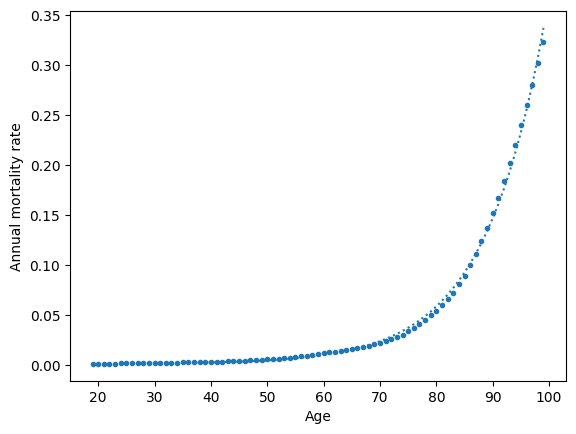

In [ ]:
life_table = pd.DataFrame({
    "Age bin lower" : np.linspace(0,99,100),
    "Age bin upper" : np.linspace(1,100,100),
    "Mortality" : [0.00544568942859769, 0.00040257113869302, 0.000254236627370119, 0.000191887069377117, 0.000161350340931676, 0.000142866410897113, 0.000129908919916488, 0.000119035452371463, 0.000107113170088269, 9.54861170612276E-05, 8.99308070074767E-05, 9.98268587864004E-05, 0.000135970505652949, 0.000204669006052427, 0.000298894156003371, 0.000405212253099307, 0.000513052917085588, 0.000622979365289211, 0.000730827625375241, 0.000836958352010697, 0.000949320499785244, 0.00106480985414237, 0.00116985128261149, 0.00125857908278704, 0.00133492052555084, 0.00140560872387141, 0.00147951999679208, 0.00156003492884338, 0.00165091559756547, 0.00174883368890733, 0.00184925447683781, 0.0019465348450467, 0.00203970144502819, 0.0021280434448272, 0.00221556331962347, 0.00230809138156474, 0.0024092432577163, 0.00251883920282125, 0.00263827270828187, 0.00276825693435967, 0.00291649089194834, 0.00307848490774632, 0.00324352458119392, 0.00340965297073126, 0.00358722521923482, 0.00379202072508633, 0.00403583887964487, 0.00431524869054556, 0.00462507316842675, 0.00495934067294002, 0.00530762085691094, 0.00568565167486668, 0.00611765449866652, 0.00661950511857867, 0.00718422327190638, 0.00776646938174963, 0.00836908537894487, 0.00904176104813814, 0.00979499705135822, 0.0106063261628151, 0.0114669734612107, 0.0123334797099233, 0.0131734628230333, 0.0139807434752584, 0.0147979333996773, 0.0156656913459301, 0.0167256686836481, 0.0178528390824795, 0.0191221758723259, 0.0205258037894964, 0.0219193808734417, 0.0235364474356174, 0.0253724660724401, 0.0276162438094616, 0.0298890620470047, 0.0337258204817772, 0.0369334556162357, 0.0410163439810276, 0.0447582602500916, 0.0495301112532616, 0.0541197210550308, 0.059482529759407, 0.0654013901948929, 0.0722243711352348, 0.0806085169315338, 0.0891392305493355, 0.0995857492089272, 0.11102119833231, 0.123483829200268, 0.137000516057014, 0.15158386528492, 0.167229443788528, 0.183913290500641, 0.201589778065681, 0.220190301537514, 0.239622786641121, 0.259772449731827, 0.280503511428833, 0.301662474870682, 0.323082149028778]
})

def gm_hazard(x, alpha, beta, gamma):
    return alpha * np.exp(beta * x) + gamma

xdata = life_table["Age bin lower"][19:]
ydata = life_table["Mortality"][19:]
popt, pcov = sp.optimize.curve_fit(
    gm_hazard,
    xdata,
    ydata,
    bounds=(0,[1,1,1]),
)
plt.plot(xdata, gm_hazard(xdata, *popt), linestyle=":")
plt.scatter(
    xdata,
    ydata,
    marker="."
)
print("fit:\th(Age) = %5.6f exp(%5.6f Age) + %5.6f" % tuple(popt))

plt.xlabel("Age")
plt.ylabel("Annual mortality rate")
plt.show()

In [71]:
nhis_data["BMI"] = nhis_data["WEIGHT"] / (nhis_data["HEIGHT"])**2 * 703.07 # psi => kg/m^2
nhis_data["BMI_STD"] = (nhis_data["BMI"] - np.mean(nhis_data["BMI"]))/np.std(nhis_data["BMI"])
nhis_data["AGE_STD"] = (nhis_data["AGE"] - np.mean(nhis_data["AGE"]))/np.std(nhis_data["AGE"])
nhis_data["HEIGHT_STD"] = (nhis_data["HEIGHT"] - np.mean(nhis_data["HEIGHT"]))/np.std(nhis_data["HEIGHT"])
nhis_data["HAS_DIABETES"] = (nhis_data["DIABTYPE"] != 0)
nhis_data["IS_BLACK"] = nhis_data["RACENEW"] == 200
nhis_data["IS_HISPANIC"] = (nhis_data["HISPETH"] != 10) & (nhis_data["HISPETH"] < 90)

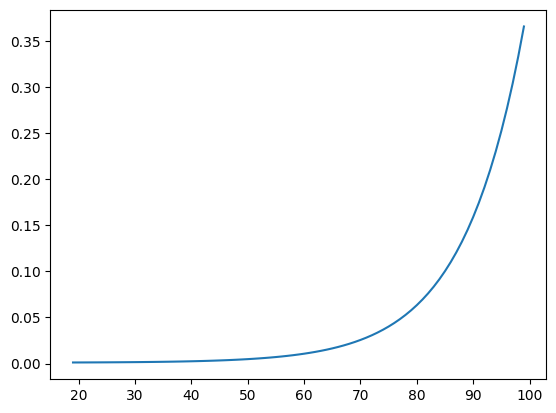

In [82]:
def general_hazard(age):
    return 0.000034 * np.exp(0.092899 * age) + 0.000915
def produce_covariates(agent):
    covariates = []
    covariates += [agent["BMI_STD"], agent["BMI_STD"]**2, agent["BMI_STD"]**3]
    covariates += [agent["IS_BLACK"], agent["IS_HISPANIC"], 0, 0, 0, 0]
    covariates += [agent["EDUC"] == 103, agent["EDUC"] == 201, agent["EDUC"] == 302, agent["EDUC"] == 301, agent["EDUC"] == 400, (agent["EDUC"] >= 500) & (agent["EDUC"] <= 505), 0]
    covariates += [0] * 31
    covariates += [0] * 6
    covariates += [0] * 8
    covariates += [0] * 5
    covariates += [0] * 5
    covariates += [agent["HAS_DIABETES"]]
    covariates += [agent["AGE_STD"]]
    covariates += [agent["HEIGHT_STD"]]
    return np.array(covariates)

# generate random profile for demonstration
np.random.seed(1)
profile_index = np.random.randint(0,nhis_data.shape[0])
profile = nhis_data.iloc[profile_index]

male_beta = np.array([0.02, 0.09, -0.01, 0.05, -0.22, -0.18, -0.12, 0.03, 0.07, 0.02, -0.04, -0.06, -0.05, -0.12, -0.19, 0.05, 0.06, 0.15, 0.21, 0.31, 0.36, 0.43, 0.32, 0.49, 0.59, 0.68, 0.55, 0.68, 0.49, 0.55, 0.74, 0.78, 0.87, 0.92, 0.71, 0.8, 0.92, 1.22, 1, 0.71, 0.77, 0.99, 1.13, 1.29, 1.31, 1.25, 0.36, -0.11, -0.23, -0.25, -0.31, -0.31, -0.17, -0.19, -0.22, -0.18, -0.06, -0.03, 0.01, -0.05, 0.08, 0.17, 0.36, 0.7, 1.25, 0.52, 0.22, 0.22, 0.19, 0.31, 0.05, 0.47, -0.03, 0.08])
female_beta = np.array([0.01, 0.07, -0.01, -0.02, -0.19, -0.28, -0.24, 0.14, 0.12, 0.05, 0.04, 0.02, 0.03, -0.01, -0.05, 0.09, 0.04, 0.21, 0.35, 0.42, 0.34, 0.55, 0.28, 0.44, 0.52, 0.77, 0.58, 0.99, 0.34, 0.58, 0.71, 0.81, 0.54, 0.64, 0.56, 0.89, 1.03, 1.07, 1.02, 0.44, 0.86, 1.12, 1.23, 1.39, 1.45, 1.53, 0.4, -0.11, -0.24, -0.26, -0.31, -0.27, -0.18, -0.18, -0.11, -0.06, 0.15, 0, 0.05, 0.01, 0.37, 0.12, 0.34, 0.67, 1.1, 0.52, 0.15, 0.12, 0.1, 0.27, 0.2, 0.62, -0.09, 0.05])

beta = male_beta if profile["SEX"] == 1 else 0
covariates = produce_covariates(profile)
plt.plot(
    xdata,
    general_hazard(xdata) * np.exp(beta @ covariates)
)

## Income
We regress household income on age, race, education, and gender.

In [117]:
ipums_usa_data = readers.read_microdata(
    ddi=readers.read_ipums_ddi("C:/Users/brand/Desktop/STAR_Delimited/IPUMS Population Data/nhis_00001.dat/usa_00005.xml"),
    filename="C:/Users/brand/Desktop/STAR_Delimited/IPUMS Population Data/nhis_00001.dat/usa_00005.dat",
)

C:\Users\brand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipumspy\readers.py:49: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.
  warnings.warn(


In [118]:
ipums_usa_data = ipums_usa_data.replace({
    "INCTOT" : {
        9999998 : np.nan,
        9999999 : np.nan,
    },
    "SEX" : {
        9 : np.nan,
    },
    "AGE" : {
        999 : np.nan,
    },
    "HISPAN" : {
        9 : np.nan,
    },
    "EDUC" : {
        99 : np.nan,
    }
})
ipums_usa_data["IS_MALE"] = (ipums_usa_data["SEX"] == "Male")
ipums_usa_data["IS_WHITE"] = (ipums_usa_data["RACE"] == 1) & (ipums_usa_data["HISPAN"] == 0)
ipums_usa_data["IS_BLACK"] = (ipums_usa_data["RACE"] == 2) & (ipums_usa_data["HISPAN"] == 0)
ipums_usa_data["IS_HISPANIC"] = (ipums_usa_data["HISPAN"] != 0)
ipums_usa_data["ATTENDED_COLLEGE"] = (ipums_usa_data["EDUC"] >= 7)

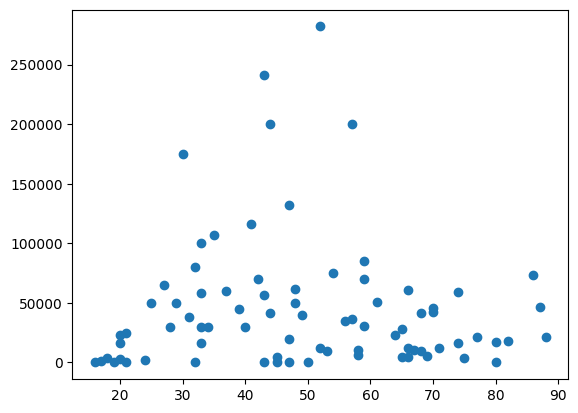

In [120]:
random_indices = np.random.randint(ipums_usa_data.shape[0], size=100)
plt.scatter(ipums_usa_data["AGE"][random_indices].astype(float), ipums_usa_data["INCTOT"][random_indices].astype(float))

In [121]:
income_model = smf.ols(formula="INCTOT ~ AGE + I(AGE**2) + IS_MALE + IS_WHITE + IS_BLACK + IS_HISPANIC + ATTENDED_COLLEGE", data=ipums_usa_data.astype(float), missing="drop")
results = income_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 INCTOT   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                 5.535e+04
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:45:08   Log-Likelihood:            -3.3904e+07
No. Observations:             2715609   AIC:                         6.781e+07
Df Residuals:                 2715602   BIC:                         6.781e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.272e+04    178.852  